In [1]:
import os
# from netCDF4 import Dataset
import netCDF4 as nc4
import pandas as pd
from tqdm import tqdm
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rc('font',family='Times New Roman') #设置全局字体

D:\Soft\code_soft\anaconda\envs\rgis9\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## 计算年均值

### 版本v1

In [61]:
# 文件夹根路径
files_path = r"D:\PhD\data\station_feather\datas_feather_GLASS"

# 初始化空列表存储所有HDF文件
all_data = []
# 遍历文件夹中的所有文件
for filename in tqdm(os.listdir(files_path)):
    # 检查文件是否为HDF文件
    if filename.endswith(".hdf"):
        file_path = os.path.join(files_path, filename)
        try:
            # 打开HDF文件
            with (nc4.Dataset(file_path, 'r') as hdf_file):
                # 获取指定数据集
                dataset = hdf_file['DSR']
                # 读取数据
                data = np.array(dataset)
                data[data == -1] = np.nan
                # 将数据添加到列表中
                all_data.append(data)

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

# 将所有数据转换为np数组
all_data_array = np.array(all_data)
# 计算平均值
mean_data = np.nanmean(all_data, axis=0)


100%|██████████| 7/7 [00:01<00:00,  3.66it/s]
C:\Users\Xvwenchao\AppData\Local\Temp\ipykernel_11308\2940097516.py:28: RuntimeWarning: Mean of empty slice
  mean_data = np.nanmean(all_data, axis=0)


### DS优化版v2

In [58]:
# 文件夹根路径
files_path = r"D:\PhD\data\station_feather\datas_feather_GLASS"
# 保存为tif文件
tif_file_path  = r"D:\PhD\data\station_feather\datas_feather_GLASS\output.tif"

# 初始化累积总和与计数数组
sum_data = None
count_data = None

# 遍历文件夹中的所有文件
for filename in tqdm(os.listdir(files_path)):
    # 检查文件是否为HDF文件
    if filename.endswith(".hdf"):
        file_path = os.path.join(files_path, filename)
        try:
            # 打开HDF文件
            with nc4.Dataset(file_path, 'r') as hdf_file:
                # 获取指定数据集
                dataset = hdf_file['DSR']
                # 读取数据并替换-1为NaN
                data = np.array(dataset)
                data[data == -1] = np.nan

                # 初始化累积数组（基于第一个文件的形状）
                if sum_data is None:
                    sum_data = np.zeros_like(data, dtype=np.float32)
                    count_data = np.zeros_like(data, dtype=np.uint16)  # 假设文件数不超过65535

                # 跳过形状不一致的文件
                if data.shape != sum_data.shape:
                    print(f"文件 {filename} 形状不匹配，已跳过")
                    continue

                # 计算有效数据掩码（非NaN区域）
                valid_mask = ~np.isnan(data)

                # 累加有效数据到总和
                sum_data[valid_mask] += data[valid_mask]
                # 更新有效计数
                count_data[valid_mask] += 1

        except Exception as e:
            print(f"处理文件 {file_path} 时出错: {e}")

# 计算全局平均值
if sum_data is not None:
    # 创建存储结果的数组，初始化为NaN
    mean_data2 = np.full_like(sum_data, np.nan, dtype=np.float32)
    # 仅在有计数的位置计算平均值
    valid_positions = count_data > 0
    mean_data[valid_positions] = sum_data[valid_positions] / count_data[valid_positions]
else:
    mean_data = None
    print("未找到有效HDF文件")

print("全年平均值为：", mean_data.mean())

data = mean_data
del mean_data
# (x方向上的像素分辨率，表示x方向上的y方向倾斜：表示x方向上的y方向倾斜，起始经度，表示y方向上的x方向倾斜，y方向上的像素分辨率常为负值，起始纬度：左上角)
transform = rasterio.transform.Affine(0.05, 0, -180, 0, -0.05, 90)
crs = rasterio.crs.CRS.from_epsg(4326)

# 打开一个新的 TIFF 文件进行写入
with rasterio.open(
    tif_file_path,
    'w',
    driver='GTiff',
    height=data.shape[0],
    width=data.shape[1],
    count=1,
    dtype=data.dtype,
    crs=crs,
    transform=transform,
) as tif_file:
    # 将数据写入 TIFF 文件
    tif_file.write(data, 1)

print(f"成功转换为 {tif_file_path}")

100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


In [3]:
all = []
a = np.array([[-1.0, 2, 3], [4, 5, 6], [7, 8, -1]])
b = np.array([[1.0, 2, 3], [4, 5, 6], [7, 8, 9]])
c = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
d = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

a[a == -1] = np.nan

all.append(a)
all.append(b)
all.append(c)
all.append(d)
all = np.array(all)

mean_data2 = np.nanmean(all, axis=0)
mean_data2.mean()

5.0

## 可视化

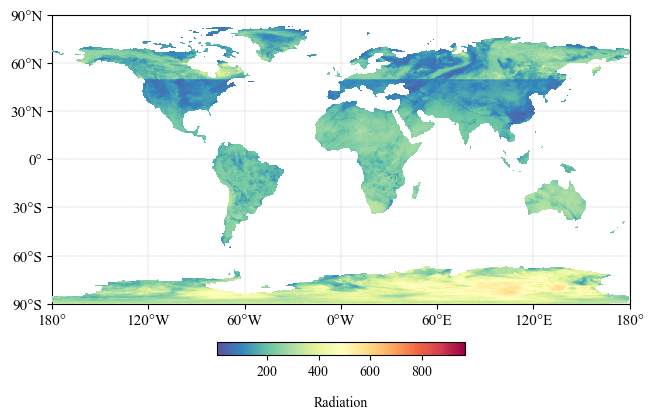

In [63]:
# 读取GeoTiff文件
src = rasterio.open(tif_file_path)
data = src.read(1) # 读取第一个波段
# nodata_value = np.nan  # 获取nodata值
nodata_value = -1  # 获取nodata值
data = np.ma.masked_where(data == nodata_value, data) # 将nodata值替换为NaN并创建掩码
extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top] # 获取图像边界

# 创建画布
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# 可视化
# im = ax.imshow(data, origin='upper', extent=extent, transform=ccrs.PlateCarree(), cmap='Spectral_r', vmin=0, vmax=400, zorder=10)
im = ax.imshow(data, origin='upper', extent=extent, transform=ccrs.PlateCarree(), cmap='Spectral_r',  zorder=10)
# im.axes.get_xaxis().set_visible(False) # 隐藏坐标轴标签
# im.axes.get_yaxis().set_visible(False)
# 添加colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=0.4, pad=0.1)
cbar.set_label("Radiation", labelpad=12)
cbar.ax.xaxis.set_label_position('bottom')
# 关闭 GeoTIFF
src.close()

# 设置 axis ticks
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.tick_params(axis='both', labelsize=11)
ax.grid(linewidth=0.2, color='#949494', linestyle='--', zorder=0)

# 设置 tick labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
plt.show()
cbar.ax.xigwgvnifigsdhihwjob